# Hypothesis testing for music library
#### - Uday Kamal

## Introduction
While exploring a database of music library which contains data of numerous songs, I wondered if I could use this data to perform a hypothesis testing based on a statement. After exploring different tables in that database I noticed few useful columns (like "Duration" column from 'tracks' table) and useful tables like artists, albums, genres and invoices table. Then finally I came to a statement for my analysis.

### Statement
#### Does a song with a duration higher/lower than the average duration of all the songs affect the business metrics of group like track owner, album owner, artist or genre ?

### Methodology
For generating the business metrics, I took a sample value of the variables. For example, while generating metrics for artists, I used ArtistId 22 as a sample to get the business metrics for that artist and same procedure is followed for album and genre.
1. Tool used for SQL execution - SQLite 3
2. Database used for analysis - Chiook Database [Check GitHub for accessing the database]
3. Type of hypothesis testing - Independent T-test.

In [1]:
#importing esential libraries
import pandas as pd
import sqlite3 as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from google.colab import files
uploaded=files.upload()

Saving chinook.db to chinook.db


In [3]:
#connecting database
db=sql.connect('chinook.db')

In [4]:
#writing a function to execute SQL queries
def Q(sql):
  res=pd.read_sql_query(sql,db,chunksize=100)
  return next(res)

### Generating the metrics using SQL

1. Metrics for tracks

In [5]:
tracks=Q('''SELECT
	High_or_Low,
	COUNT(High_or_Low) AS Number_of_tracks,
	SUM(Tracks_ordered_binary) AS Tracks_ordered
FROM 
(SELECT
	Test_event.TrackId,
	High_or_Low,
	MAX(CASE WHEN Test_event.TrackId=invoice_items.TrackId THEN 1 ELSE 0 END) AS Tracks_ordered_binary 
	
FROM
(SELECT
	Duration.TrackId AS TrackId,
	High_or_Low
FROM 
(SELECT 
	TrackId,
	MAX(CASE WHEN Milliseconds<393599.212103911 THEN 1 ELSE 0 END) AS High_or_Low
FROM tracks 
GROUP BY
  TrackId) Duration
GROUP by
	TrackId,
	Duration.TrackId
) Test_event
LEFT JOIN 
	invoice_items
ON 
	Test_event.TrackId=invoice_items.TrackId
GROUP BY
	Test_event.TrackId) test
GROUP BY
	High_or_Low''')
tracks.insert(1,'Average Duration',['High','Low'])
tracks=tracks.rename(columns={'Test_Album_Title':'Sample Name of album'})

2. Metrics for albums

In [6]:
albums=Q('''SELECT
	test.Test_Album_Title,
	test.AlbumId,
	High_or_Low,
	COUNT(High_or_Low) AS Number_of_tracks,
	SUM(Tracks_ordered_binary) AS Tracks_ordered
FROM 
(SELECT
	Test_event.Title AS Test_Album_Title,
	Test_event.AlbumId,
	Test_event.TrackId,
	Test_event.Name,
	High_or_Low,
	MAX(CASE WHEN Test_event.TrackId=invoice_items.TrackId THEN 1 ELSE 0 END) AS Tracks_ordered_binary
	
FROM
(SELECT
	albums.Title AS Title,
	Duration.Name,
	Duration.TrackId AS TrackId,
	albums.AlbumId,
	albums.ArtistId,
	High_or_Low
FROM 
(SELECT 
	AlbumId,
	Name,
	TrackId,
	MAX(CASE WHEN Milliseconds<393599.212103911 THEN 1 ELSE 0 END) AS High_or_Low
FROM tracks 
GROUP BY
  TrackId) Duration
INNER JOIN
	(SELECT *
	FROM albums
	WHERE AlbumId=20) albums
ON
	Duration.AlbumId=albums.AlbumId
GROUP by
	albums.Title,
	Duration.TrackId
) Test_event
LEFT JOIN 
	invoice_items
ON 
	Test_event.TrackId=invoice_items.TrackId
GROUP BY
	Test_event.TrackId) test
GROUP BY
	High_or_Low''')

albums.insert(1,'Average Duration',['High','Low'])
albums=albums.rename(columns={'Test_Album_Title':'Sample Name of album'})

3. Metrics for artists

In [7]:
artists=Q('''SELECT
	test.Test_Name_of_artist,
	test.ArtistId AS ArtistId,
	High_or_Low,
	COUNT(High_or_Low) AS Number_of_tracks,
	SUM(Tracks_ordered_binary) AS Tracks_ordered
FROM 
(SELECT
	Artists_.Test_Name_of_artist AS Test_Name_of_artist,
	Artists_.ArtistId,
	Artists_.TrackId,
	High_or_Low,
	MAX(CASE WHEN Artists_.TrackId=invoice_items.TrackId THEN 1 ELSE 0 END) AS Tracks_ordered_binary
	
FROM
(SELECT 
	artists.Name AS Test_Name_of_artist,
	Artists.ArtistId AS ArtistId,
	artists.ArtistId AS ArtistId,
	High_or_Low,
	albums.TrackId AS TrackId
FROM
(SELECT
	albums.ArtistId,
	Duration.Name,
	Duration.TrackId AS TrackId,
	High_or_Low
FROM 
(SELECT 
	AlbumId,
	Name,
	TrackId,
	MAX(CASE WHEN Milliseconds<393599.212103911 THEN 1 ELSE 0 END) AS High_or_Low
FROM tracks 
GROUP BY
  TrackId) Duration
INNER JOIN
	albums
ON
	Duration.AlbumId=albums.AlbumId
GROUP by
	albums.Title,
	Duration.TrackId
) albums
INNER JOIN
	(SELECT *
	FROM artists
	WHERE ArtistId=22
	)Artists
ON
	albums.ArtistId=Artists.ArtistId
GROUP BY
	Artists.Name,
	albums.TrackId) Artists_
LEFT JOIN 
	invoice_items
ON 
	Artists_.TrackId=invoice_items.TrackId
GROUP BY
	Artists_.TrackId) test
GROUP BY
	High_or_Low''')
artists.insert(1,'Average Duration',['High','Low'])
artists=artists.rename(columns={'Test_Name_of_artist':'Sample Name of artist'})

4. Metrics for genre

In [8]:
genres=Q('''SELECT
	test.Test_Genre_Name,
	High_or_Low,
	COUNT(High_or_Low) AS Number_of_tracks,
	SUM(Tracks_ordered_binary) AS Tracks_ordered
FROM 
(SELECT
	Test_event.Genre AS Test_Genre_Name,
	Test_event.TrackId,
	Test_event.GenreId AS Test_GenreId,
	High_or_Low,
	MAX(CASE WHEN Test_event.TrackId=invoice_items.TrackId THEN 1 ELSE 0 END) AS Tracks_ordered_binary
	
FROM
(SELECT
	genres.Name AS Genre,
	genres.GenreId AS GenreId,
	Duration.Name,
	Duration.TrackId AS TrackId,
	High_or_Low
FROM 
(SELECT 
	GenreId,
	Name,
	TrackId,
	MAX(CASE WHEN Milliseconds<393599.212103911 THEN 1 ELSE 0 END) AS High_or_Low
FROM tracks 
GROUP BY
  TrackId) Duration
INNER JOIN
	(SELECT *
	FROM genres
	WHERE GenreId=3
	) genres
ON
	Duration.GenreId=genres.GenreId
GROUP by
	genres.Name,
	Duration.TrackId
) Test_event
LEFT JOIN 
	invoice_items
ON 
	Test_event.TrackId=invoice_items.TrackId
GROUP BY
	Test_event.TrackId) test
GROUP BY
	High_or_Low''')
#genres
genres.insert(1,'Average Duration',['High','Low'])
#genres=genres.replace(to_replace =[0,1],value =['High','Low'])
genres=genres.rename(columns={'Test_Genre_Name':'Sample Name of genre'})

### Metrics in dataframe

1. Tracks

In [9]:
tracks

,High_or_Low,Average Duration,Number_of_tracks,Tracks_ordered
0,0,High,494,274
1,1,Low,3009,1710


2. Artist

In [10]:
artists

,Sample Name of artist,Average Duration,ArtistId,High_or_Low,Number_of_tracks,Tracks_ordered
0,Led Zeppelin,High,22,0,28,19
1,Led Zeppelin,Low,22,1,86,58


3. Album

In [11]:
albums

,Sample Name of album,Average Duration,AlbumId,High_or_Low,Number_of_tracks,Tracks_ordered
0,The Best Of Buddy Guy - The Millenium Collection,High,20,0,2,1
1,The Best Of Buddy Guy - The Millenium Collection,Low,20,1,9,5


4. Genre

In [12]:
genres

,Sample Name of genre,Average Duration,High_or_Low,Number_of_tracks,Tracks_ordered
0,Metal,High,0,74,50
1,Metal,Low,1,300,181


### Visualising the mterics

1. Tracks

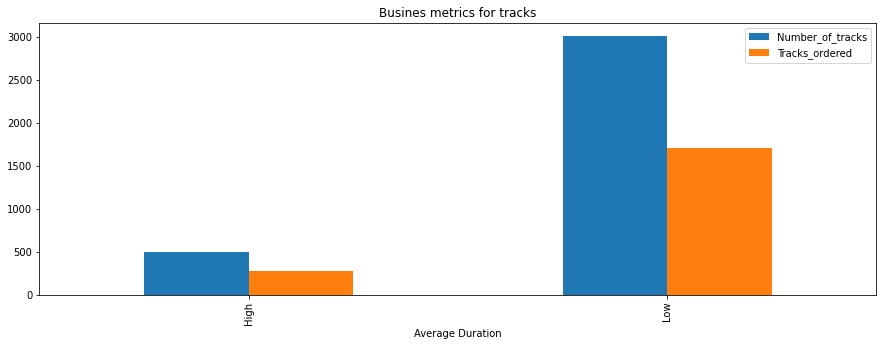

In [13]:
#plt.figure(figsize=(20,10))
tracks.plot(x='Average Duration',y=['Number_of_tracks','Tracks_ordered'],kind='bar')
plt.title('Busines metrics for tracks')
plt.gcf().set_size_inches(15,5)

2. Album

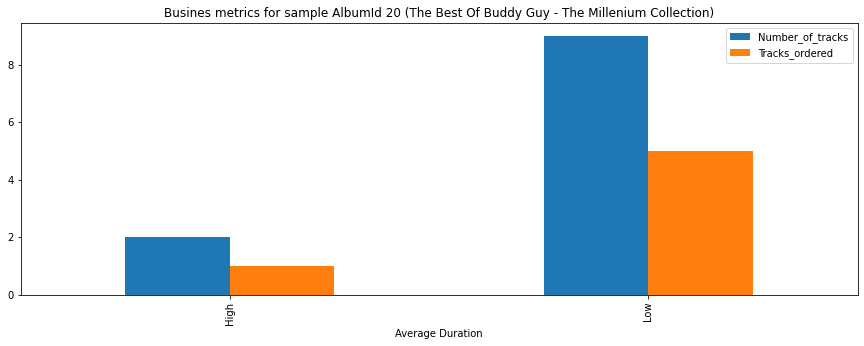

In [14]:
albums.plot(x='Average Duration',y=['Number_of_tracks','Tracks_ordered'],kind='bar')
plt.title('Busines metrics for sample AlbumId 20 (The Best Of Buddy Guy - The Millenium Collection)')
plt.gcf().set_size_inches(15,5)

3. Artist


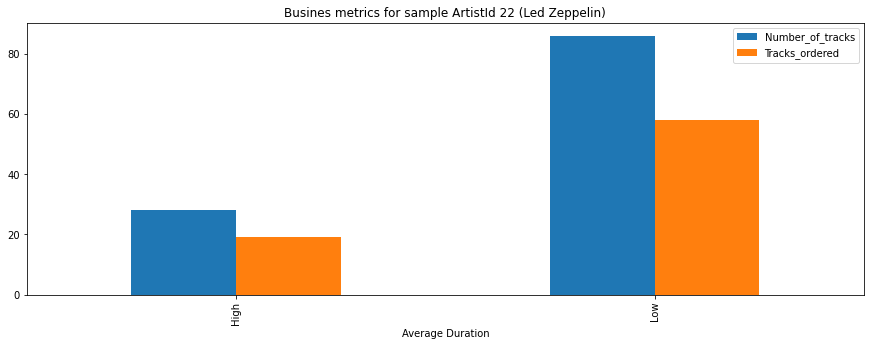

In [15]:
artists.plot(x='Average Duration',y=['Number_of_tracks','Tracks_ordered'],kind='bar')
plt.title('Busines metrics for sample ArtistId 22 (Led Zeppelin)')
plt.gcf().set_size_inches(15,5)

4. Genre

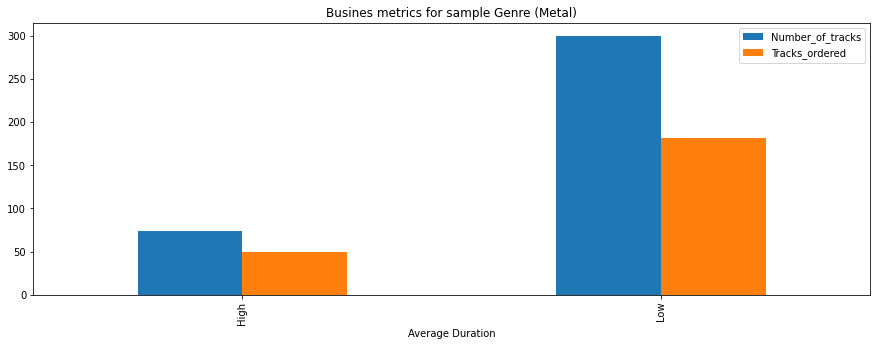

In [16]:
genres.plot(x='Average Duration',y=['Number_of_tracks','Tracks_ordered'],kind='bar')
plt.title('Busines metrics for sample Genre (Metal)')
plt.gcf().set_size_inches(15,5)

### **Hypothesis Testing using T-test**
A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features. It is mostly used when the data sets, like the data set recorded as the outcome from flipping a coin 100 times, would follow a normal distribution and may have unknown variances. A t-test is used as a hypothesis testing tool, which allows testing of an assumption applicable to a population. 
#### **Understanding $\alpha$ and p-value**

*   The p-value is the probability of rejecting the null hypothesis ($H_0$) when the null hypothesis is true. In other words, it gives the likelihood of alternate hypothesis ($H_a$) when the null hypothesis is true.
* For example, if $H_0$ = 100 & $H_a$ >= 100, and if we get a p-value of 0.02, then it means that there is a 2% chance of getting a value of 100 or more.
*   $\alpha$ denotes the measure of Significance level and is usually kept at 0.05
* If p-value is greater than $\alpha$ then we fail to reject null hypothesis ($H_0$)
* If p-value is smaller than $\alpha$ then we reject the null hypothesis and accept alternate hypothesis ($H_a$).


 
Now we can perform this test in python using the scipy.stats library. But first lets state our null hypothesis ($H_0$) and alternate hypothesis ($H_a$).

### $H_0$ : There is no difference in total number of orders with respect to the duration of the songs. 
### $H_a$ : There is a significant difference in total number of orders with respect to the duration of the songs.

In [20]:
import scipy.stats

I am using the T-test between 'High_or_Low' column & 'Tracks_ordered' in every dataframe metric obtained previously and assigning a variable to each of them respectively.

In [21]:
test_track=scipy.stats.ttest_ind(tracks['Number_of_tracks'],tracks['Tracks_ordered'])
test_album=scipy.stats.ttest_ind(albums['Number_of_tracks'],albums['Tracks_ordered'])
test_artist=scipy.stats.ttest_ind(artists['Number_of_tracks'],artists['Tracks_ordered'])
test_genre=scipy.stats.ttest_ind(genres['Number_of_tracks'],genres['Tracks_ordered'])

As the P-value for all the metrics have been obtained, lets create a dataframe which contains a column for name of the metrics and column of p-value for the correponding metric as shown.

### Results

In [22]:
data = [['Tracks', test_track[1]], ['Albums', test_album[1]], ['Artists', test_artist[1]],['Genres',test_genre[1]]]
df = pd.DataFrame(data, columns = ['Metric', 'P-value'])
df

,Metric,P-value
0,Tracks,0.652267
1,Albums,0.598390
2,Artists,0.649427
3,Genres,0.639012


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



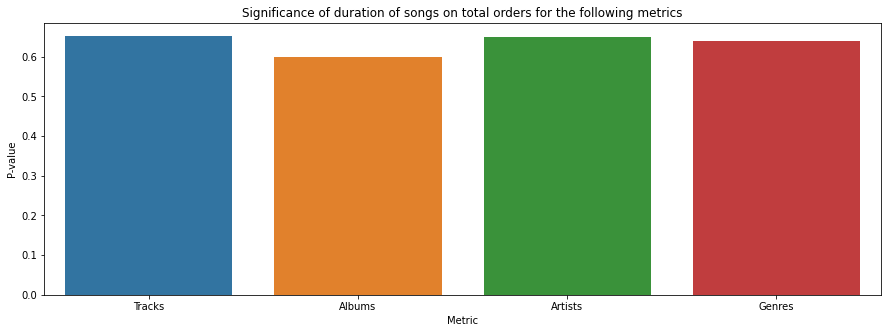

In [23]:
sns.barplot(df['Metric'],df['P-value'])
plt.title('Significance of duration of songs on total orders for the following metrics')
plt.gcf().set_size_inches(15,5)

### Conclusion
Since after hypothesis testing for every business metric, we observed that none of them had a p-value smaller than $\alpha$ (i.e 0.05) which means, we fail to reject the null hypothesis as there no further evidence to show the variance in number of orders based on the duration of that song for any metric.